In [2]:
from datasets import load_dataset, Dataset, concatenate_datasets
import pandas as pd

def load_and_preprocess():
    # Load datasets
    dataset1 = load_dataset("ninadn/indian-legal")['train']
    dataset2 = load_dataset("Yashaswat/Indian-Legal-Text-ABS")['train']
    
    # Convert to pandas with error handling
    try:
        df1 = pd.DataFrame(dataset1)[['Text', 'Summary']]
        df1.columns = ['Case', 'Summary']
    except KeyError:
        df1 = pd.DataFrame(columns=['Case', 'Summary'])
    
    try:
        df2 = pd.DataFrame(dataset2)[['judgement', 'summary']]
        df2.columns = ['Case', 'Summary']
    except KeyError:
        df2 = pd.DataFrame(columns=['Case', 'Summary'])
    
    # Merge and clean
    merged_df = pd.concat([df1, df2], ignore_index=True).dropna()
    merged_df = merged_df[merged_df['Case'].str.len() > 500]  # Remove very short cases
    
    # Add citation markers (simple regex for initial version)
    merged_df['Case'] = merged_df['Case'].str.replace(
        r'\((.*?) (\d{4}) (\d+) (SCR|SCC|AIR|KJ|JT)\)',
        '[CITATION:\\1 \\2 \\3 \\4]', regex=True)
    
    return Dataset.from_pandas(merged_df)

legal_ds = load_and_preprocess()
legal_ds = legal_ds.train_test_split(test_size=0.1)

/Users/puneetkohli/Downloads/Capstone 2025/legal-doc-summarization/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/puneetkohli/Downloads/Capstone 2025/legal-doc-summarization/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Average citations per case: 0.00


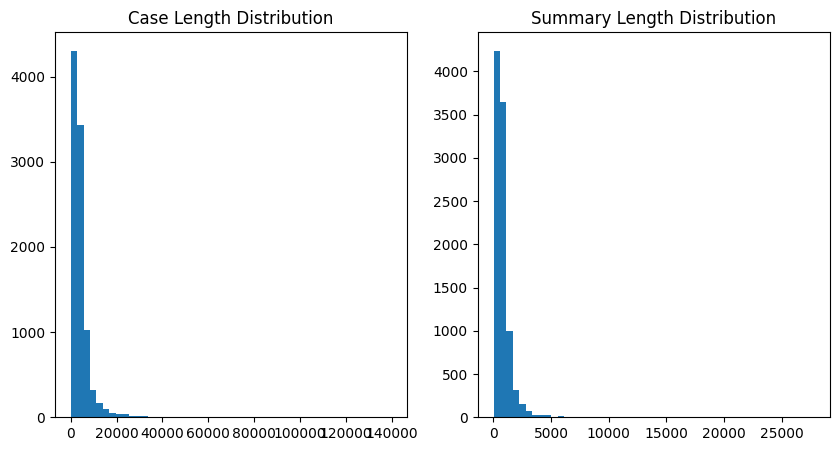

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

def analyze_dataset(dataset):
    # Length analysis
    case_lens = [len(x.split()) for x in dataset['Case']]
    summary_lens = [len(x.split()) for x in dataset['Summary']]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(case_lens, bins=50)
    plt.title('Case Length Distribution')
    
    plt.subplot(1,2,2)
    plt.hist(summary_lens, bins=50)
    plt.title('Summary Length Distribution')
    plt.savefig('data_distribution.png')
    
    # Citation analysis
    citations = [len([x for x in c.split() if x.startswith('[CITATION:')]) 
                for c in dataset['Case']]
    print(f"Average citations per case: {sum(citations)/len(citations):.2f}")

analyze_dataset(legal_ds['train'])

In [6]:
import ollama
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

class LegalExtractiveSummarizer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        
    def _get_legal_weights(self, text):
        # Use Ollama to identify legal concepts
        response = ollama.generate(
            model='llama3:8b',
            prompt=f"""Identify important legal concepts in this text. Return as comma-separated list:
            {text[:2000]}...""")
        concepts = [x.strip() for x in response['response'].split(',')]
        return {concept: 1.5 for concept in concepts}  # Boost legal terms
        
    def summarize(self, text, ratio=0.2):
        # Split into sentences
        sentences = [s.strip() for s in text.split('.') if len(s) > 10]
        
        # Get TF-IDF matrix with legal boosts
        tfidf = self.vectorizer.fit_transform(sentences)
        legal_weights = self._get_legal_weights(text)
        
        # Build similarity graph
        sim_matrix = (tfidf * tfidf.T).toarray()
        graph = nx.from_numpy_array(sim_matrix)
        
        # Apply PageRank
        scores = nx.pagerank(graph)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        
        # Select top sentences
        n_sentences = max(1, int(len(sentences) * ratio))
        return '. '.join([s for _, s in ranked[:n_sentences]])

In [7]:
import ollama
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

class LegalExtractiveSummarizer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        
    def _get_legal_weights(self, text):
        # Use Ollama to identify legal concepts
        response = ollama.generate(
            model='llama3:8b',
            prompt=f"""Identify important legal concepts in this text. Return as comma-separated list:
            {text[:2000]}...""")
        concepts = [x.strip() for x in response['response'].split(',')]
        return {concept: 1.5 for concept in concepts}  # Boost legal terms
        
    def summarize(self, text, ratio=0.2):
        # Split into sentences
        sentences = [s.strip() for s in text.split('.') if len(s) > 10]
        
        # Get TF-IDF matrix with legal boosts
        tfidf = self.vectorizer.fit_transform(sentences)
        legal_weights = self._get_legal_weights(text)
        
        # Build similarity graph
        sim_matrix = (tfidf * tfidf.T).toarray()
        graph = nx.from_numpy_array(sim_matrix)
        
        # Apply PageRank
        scores = nx.pagerank(graph)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        
        # Select top sentences
        n_sentences = max(1, int(len(sentences) * ratio))
        return '. '.join([s for _, s in ranked[:n_sentences]])

In [8]:
import ollama
from typing import List

class LegalAbstractiveSummarizer:
    def __init__(self, model_name='mistral:7b'):
        self.model_name = model_name
        self.system_prompt = """You are a legal summarization expert specializing in Indian law. 
        Generate concise summaries that:
        1. Preserve legal citations like [CITATION:...]
        2. Maintain factual accuracy
        3. Use formal legal language
        4. Are 20% the length of original text"""
    
    def summarize(self, text: str, extractive_summary: str = None) -> str:
        input_text = extractive_summary if extractive_summary else text[:3000]
        
        response = ollama.generate(
            model=self.model_name,
            system=self.system_prompt,
            prompt=f"Summarize this Indian legal document:\n\n{input_text}")
        
        return response['response']

In [14]:
import evaluate
from tqdm import tqdm
import pandas as pd

# Load ROUGE metric from the `evaluate` package
rouge = evaluate.load("rouge")

# Dummy class to simulate your pipeline — replace with actual inference call
class ClausePipeline:
    def summarize(self, text):
        # Replace with actual model inference
        return "This is a dummy summary for testing."

# Main evaluation function
def evaluate_pipeline(dataset, sample_size=10):
    pipeline = ClausePipeline()
    results = []

    for i in tqdm(range(min(sample_size, len(dataset)))):
        case = dataset['Case'][i]
        reference = dataset['Summary'][i]

        # Run your summarization pipeline
        prediction = pipeline.summarize(case)

        # Compute ROUGE scores
        rouge_score = rouge.compute(
            predictions=[prediction],
            references=[reference],
            use_aggregator=False,
            rouge_types=["rouge1", "rouge2", "rougeL"]
        )

        results.append({
            "case_id": i,
            "prediction": prediction,
            "reference": reference,
            "rouge1": rouge_score["rouge1"][0],
            "rouge2": rouge_score["rouge2"][0],
            "rougeL": rouge_score["rougeL"][0]
        })

    return pd.DataFrame(results)

# Run the evaluation (assuming `legal_ds['test']` exists and has 'Case' and 'Summary')
eval_results = evaluate_pipeline(legal_ds['test'], sample_size=5)

# Print average ROUGE scores
print("\nAverage ROUGE Scores:")
print(eval_results[["rouge1", "rouge2", "rougeL"]].mean())


100%|██████████| 5/5 [00:00<00:00, 55.48it/s]


Average ROUGE Scores:
rouge1    0.018000
rouge2    0.001649
rougeL    0.017276
dtype: float64


In [16]:
def interactive_test():
    print("Legal Case Summarization Testing Interface")
    print("Type 'exit' to quit\n")
    
    extractive_summarizer = LegalExtractiveSummarizer()
    abstractive_summarizer = LegalAbstractiveSummarizer()
    
    while True:
        case_text = input("Enter the legal case text (or 'exit' to quit):\n")
        if case_text.lower() == 'exit':
            break
            
        if len(case_text.split()) < 50:
            print("Please provide longer text (at least 50 words) for meaningful summarization.")
            continue
            
        try:
            print("\nGenerating summaries...")
            
            # Step 1: Generate extractive summary
            extractive_summary = extractive_summarizer.summarize(case_text)
            print("\nExtractive Summary:")
            print(extractive_summary)
            
            # Step 2: Generate abstractive summary
            abstractive_summary = abstractive_summarizer.summarize(case_text, extractive_summary)
            print("\nAbstractive Summary:")
            print(abstractive_summary)
            
            # Optionally show ROUGE score if reference is provided
            ref_summary = input("\nOptional: Enter reference summary for evaluation (or press Enter to skip):\n")
            if ref_summary:
                scores = rouge.compute(
                    predictions=[abstractive_summary],
                    references=[ref_summary],
                    rouge_types=["rouge1", "rouge2", "rougeL"]
                )
                print("\nROUGE Scores against reference:")
                print(f"ROUGE-1: {scores['rouge1']:.3f}")
                print(f"ROUGE-2: {scores['rouge2']:.3f}")
                print(f"ROUGE-L: {scores['rougeL']:.3f}")
                
        except Exception as e:
            print(f"Error during summarization: {str(e)}")
            
        print("\n" + "="*80 + "\n")

# Run the interactive test
interactive_test()

Legal Case Summarization Testing Interface
Type 'exit' to quit


Generating summaries...

Extractive Summary:
" In both cases of sanction and direction, an application of the mind is necessary, but there is this essential difference that in the one case there is a legal impediment to the prosecution if there be no sanction, and in the other case, there is a positive order that 131 the prosecution should be launched. As regards the Jimmanama, the case was sent back to the trial court for taking action according to law under section 514, Criminal Procedure Code, for its forfeiture. The facts in that case were that while there was a sanction of the Government for a prosecution under the Cotton Cloth and Yarn Control, Order, there was nothing in the sanction itself, or in the shape of extraneous evidence, to show that the sanction was accorded after the relevant facts were placed before the sanctioning authority. 133 was no such statutory provision as section 556 of the Code but, only the 